In [1]:
import os
import numpy as np

import numpy as np
import librosa
import soundfile as sf
from IPython.display import Audio

import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from scipy import stats
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, Dropout, concatenate, UpSampling2D, Cropping2D, ZeroPadding2D, Add
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError

In [2]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [4]:
# Function to pad or truncate spectrograms to a common shape
def pad_or_truncate_spectrogram(spectrogram, target_shape):
    if spectrogram.shape[1] > target_shape[1]:
        spectrogram = spectrogram[:, :target_shape[1]]
    padded_spectrogram = np.pad(spectrogram,
                                ((0, target_shape[0] - spectrogram.shape[0]),
                                 (0, target_shape[1] - spectrogram.shape[1])),
                                mode='constant')
    return padded_spectrogram

In [5]:
# Function to load and pad/truncate magnitude and phase files from directories with a limit
def load_files_with_limit(magnitude_dir, phase_dir, target_shape, limit=8000):
    # List magnitude and phase files
    magnitude_files = [f for f in os.listdir(magnitude_dir) if f.endswith('_magnitude.npy')]
    phase_files = [f for f in os.listdir(phase_dir) if f.endswith('_phase.npy')]

    # Sort files to ensure order
    magnitude_files.sort()
    phase_files.sort()

    # Create dictionaries to pair files based on the prefix
    magnitude_dict = {f.split('_magnitude.npy')[0]: f for f in magnitude_files}
    phase_dict = {f.split('_phase.npy')[0]: f for f in phase_files}

    # Find common keys (i.e., common prefixes)
    common_keys = sorted(set(magnitude_dict.keys()).intersection(set(phase_dict.keys())))

    # Limit the number of files processed
    common_keys = common_keys[:limit]

    magnitudes = []
    phases = []
    file_names = []
    count = 0 

    for key in common_keys:
        try:
            count += 1
            magnitude_file = magnitude_dict[key]
            phase_file = phase_dict[key]
            print(f"Processing file pair {count}: {magnitude_file}, {phase_file}")
            
            magnitude_path = os.path.join(magnitude_dir, magnitude_file)
            phase_path = os.path.join(phase_dir, phase_file)

            # Load the arrays
            magnitude = np.load(magnitude_path)
            phase = np.load(phase_path)

            # Pad or truncate the spectrograms to the target shape
            magnitude = pad_or_truncate_spectrogram(magnitude, target_shape)
            phase = pad_or_truncate_spectrogram(phase, target_shape)

            magnitudes.append(magnitude)
            phases.append(phase)
            file_names.append(key)
        except Exception as e:
            print(f"Error loading files {magnitude_file} and {phase_file}: {e}")
            continue

    return np.array(magnitudes), np.array(phases), file_names

In [6]:
# Define directories for magnitude and phase files
noisy_magnitude_dir = 'dataset/noisy arrays'
noisy_phase_dir = 'dataset/noisy arrays'
clean_magnitude_dir = 'dataset/clean arrays'
clean_phase_dir = 'dataset/clean arrays'


# Set the limit and target shape
limit = 8000
target_shape = (1025, 600)  # Example shape, adjust as necessary

# Load the clean and noisy magnitude and phase data with the specified limit
clean_magnitudes, clean_phases, clean_file_names = load_files_with_limit(clean_magnitude_dir, clean_phase_dir, target_shape, limit)
noisy_magnitudes, noisy_phases, noisy_file_names = load_files_with_limit(noisy_magnitude_dir, noisy_phase_dir, target_shape, limit)
# Load the data
# noisy_data, clean_data, file_names = load_files_with_limit(noisy_magnitude_dir, clean_magnitude_dir, target_shape)

Processing file pair 1: p234_001_magnitude.npy, p234_001_phase.npy
Processing file pair 2: p234_002_magnitude.npy, p234_002_phase.npy
Processing file pair 3: p234_003_magnitude.npy, p234_003_phase.npy
Processing file pair 4: p234_004_magnitude.npy, p234_004_phase.npy
Processing file pair 5: p234_005_magnitude.npy, p234_005_phase.npy
Processing file pair 6: p234_006_magnitude.npy, p234_006_phase.npy
Processing file pair 7: p234_007_magnitude.npy, p234_007_phase.npy
Processing file pair 8: p234_008_magnitude.npy, p234_008_phase.npy
Processing file pair 9: p234_009_magnitude.npy, p234_009_phase.npy
Processing file pair 10: p234_010_magnitude.npy, p234_010_phase.npy
Processing file pair 11: p234_012_magnitude.npy, p234_012_phase.npy
Processing file pair 12: p234_013_magnitude.npy, p234_013_phase.npy
Processing file pair 13: p234_014_magnitude.npy, p234_014_phase.npy
Processing file pair 14: p234_015_magnitude.npy, p234_015_phase.npy
Processing file pair 15: p234_016_magnitude.npy, p234_016

In [7]:
clean_magnitudes.shape

(8000, 1025, 600)

In [8]:
noisy_magnitudes.shape

(8000, 1025, 600)

In [9]:
# Define the U-Net model
def unet3003(input_size=(1025, 600, 1)):
    size_filter_in = 16
    kernel_init = 'he_normal'
    activation_layer = None

    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(size_filter_in, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(inputs)
    conv1 = LeakyReLU()(conv1)
    conv1 = Conv2D(size_filter_in, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(conv1)
    conv1 = LeakyReLU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(size_filter_in * 2, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(pool1)
    conv2 = LeakyReLU()(conv2)
    conv2 = Conv2D(size_filter_in * 2, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(conv2)
    conv2 = LeakyReLU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(size_filter_in * 4, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(pool2)
    conv3 = LeakyReLU()(conv3)
    conv3 = Conv2D(size_filter_in * 4, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(conv3)
    conv3 = LeakyReLU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(size_filter_in * 8, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(pool3)
    conv4 = LeakyReLU()(conv4)
    conv4 = Conv2D(size_filter_in * 8, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(conv4)
    conv4 = LeakyReLU()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(size_filter_in * 16, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(pool4)
    conv5 = LeakyReLU()(conv5)
    conv5 = Conv2D(size_filter_in * 16, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(conv5)
    conv5 = LeakyReLU()(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = UpSampling2D(size=(2, 2))(drop5)
    up6 = Conv2D(size_filter_in * 8, 2, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(up6)
    up6 = LeakyReLU()(up6)
    up6 = tf.image.resize(up6, conv4.shape[1:3])
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(size_filter_in * 8, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(merge6)
    conv6 = LeakyReLU()(conv6)
    conv6 = Conv2D(size_filter_in * 8, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(conv6)
    conv6 = LeakyReLU()(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(size_filter_in * 4, 2, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(up7)
    up7 = LeakyReLU()(up7)
    up7 = tf.image.resize(up7, conv3.shape[1:3])
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(size_filter_in * 4, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(merge7)
    conv7 = LeakyReLU()(conv7)
    conv7 = Conv2D(size_filter_in * 4, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(conv7)
    conv7 = LeakyReLU()(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(size_filter_in * 2, 2, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(up8)
    up8 = LeakyReLU()(up8)
    up8 = tf.image.resize(up8, conv2.shape[1:3])
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(size_filter_in * 2, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(merge8)
    conv8 = LeakyReLU()(conv8)
    conv8 = Conv2D(size_filter_in * 2, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(conv8)
    conv8 = LeakyReLU()(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Conv2D(size_filter_in, 2, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(up9)
    up9 = LeakyReLU()(up9)
    up9 = tf.image.resize(up9, conv1.shape[1:3])
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(size_filter_in, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(merge9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(size_filter_in, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(conv9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(2, 3, activation=activation_layer, padding='same', kernel_initializer=kernel_init)(conv9)
    conv9 = LeakyReLU()(conv9)
    conv10 = Conv2D(1, 1, activation='tanh')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics=['mae', MeanSquaredError(), RootMeanSquaredError()])

    model.summary()

    return model

In [10]:
def normalize_spectrograms(spectrograms):
    max_value = np.max(np.abs(spectrograms))
    if max_value > 0:
        return spectrograms / max_value, max_value
    else:
        return spectrograms, max_value

In [11]:
X_in = noisy_magnitudes
print(X_in.shape)
X_ou = clean_magnitudes
print(X_ou.shape)
# Predicting the noise 
X_ou = X_in - X_ou

(8000, 1025, 600)
(8000, 1025, 600)


In [12]:
# print(stats.describe(X_in.reshape(-1, 1)))
# print(stats.describe(X_ou.reshape(-1, 1)))

In [13]:
# To scale between -1 and 1
X_in, max_value_in = normalize_spectrograms(X_in)
X_ou, max_value_ou = normalize_spectrograms(X_ou)

In [14]:
# # Check shape of spectrograms
# print(X_in.shape)
# print(X_ou.shape)
# #Check new distribution
# # Check new distribution
# print(stats.describe(X_in.reshape(-1, 1)))
# print(stats.describe(X_ou.reshape(-1, 1)))

In [15]:
#Reshape for training
X_in = X_in[:,:,:]
X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)
X_ou = X_ou[:,:,:]
X_ou = X_ou.reshape(X_ou.shape[0],X_ou.shape[1],X_ou.shape[2],1)

In [16]:
print(X_in.shape,X_ou.shape)

(8000, 1025, 600, 1) (8000, 1025, 600, 1)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_in, X_ou, test_size=0.10, random_state=42)

In [18]:
generator_nn=unet3003()

2024-08-30 17:16:24.243102: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-30 17:16:25.066447: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78936 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2024-08-30 17:16:25.068108: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78936 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:81:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1025, 600,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 1025, 600, 1  160         ['input_1[0][0]']                
                                6)                                                                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 1025, 600, 1  0           ['conv2d[0][0]']                 
                                6)                                                            

In [19]:
history = generator_nn.fit(X_train, y_train, epochs=10, batch_size=16, shuffle=True, verbose=1, validation_data=(X_test, y_test))

2024-08-30 17:16:25.770431: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 17712000000 exceeds 10% of free system memory.
2024-08-30 17:16:32.226596: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 17712000000 exceeds 10% of free system memory.
2024-08-30 17:16:38.885383: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 17712000000 exceeds 10% of free system memory.
2024-08-30 17:16:47.353148: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 17712000000 exceeds 10% of free system memory.


Epoch 1/10


2024-08-30 17:16:55.526572: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/huber_loss/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-30 17:16:56.248622: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2024-08-30 17:17:01.773487: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


450/450 [==============================] - 170s 355ms/step - loss: 0.0032 - mae: 0.0314 - mean_squared_error: 0.0064 - root_mean_squared_error: 0.0801 - val_loss: 0.0012 - val_mae: 0.0226 - val_mean_squared_error: 0.0023 - val_root_mean_squared_error: 0.0482
Epoch 2/10
450/450 [==============================] - 163s 362ms/step - loss: 9.9659e-04 - mae: 0.0204 - mean_squared_error: 0.0020 - root_mean_squared_error: 0.0446 - val_loss: 0.0032 - val_mae: 0.0637 - val_mean_squared_error: 0.0063 - val_root_mean_squared_error: 0.0794
Epoch 3/10
450/450 [==============================] - 168s 374ms/step - loss: 7.0465e-04 - mae: 0.0167 - mean_squared_error: 0.0014 - root_mean_squared_error: 0.0375 - val_loss: 0.0062 - val_mae: 0.0875 - val_mean_squared_error: 0.0123 - val_root_mean_squared_error: 0.1110
Epoch 4/10
450/450 [==============================] - 168s 372ms/step - loss: 6.5469e-04 - mae: 0.0160 - mean_squared_error: 0.0013 - root_mean_squared_error: 0.0362 - val_loss: 0.0084 - val_ma

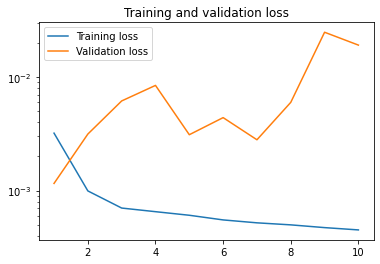

In [20]:
#Plot training and validation loss
from matplotlib import pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.yscale('log')
plt.title('Training and validation loss')
plt.legend()
plt.show()

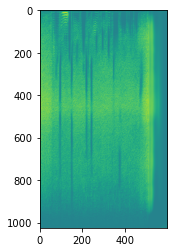

In [21]:
# Select a single item from the test set for prediction
example_id = 0  # Change the index to visualize different samples
X_single_test = X_test[example_id:example_id + 1]

# Predict and QC the output on the single item
X_pred_single_test = generator_nn.predict(X_single_test)

import matplotlib.pyplot as plt
%matplotlib inline
id = 0
plt.imshow(X_pred_single_test[id,:,:,0])

In [22]:
# Choose an example to visualize and reconstruct
predicted_magnitude = X_pred_single_test[0, :, :, 0]

print(predicted_magnitude)

[[ 0.03713256 -0.04327293 -0.03730725 ...  0.01993438  0.01939082
  -0.00698233]
 [-0.09080169 -0.02915146 -0.07579974 ...  0.033931    0.03690281
   0.00431141]
 [ 0.04150731  0.05674122 -0.02398937 ...  0.0396351   0.03646378
   0.0022049 ]
 ...
 [ 0.00721738 -0.04118365 -0.02014302 ...  0.03443367  0.02088229
   0.00243584]
 [-0.01168387 -0.05329041  0.02053044 ...  0.01622477  0.00501082
  -0.00393217]
 [-0.0121705  -0.06040505  0.01894122 ...  0.02039077  0.00917027
   0.00605743]]


In [23]:
# #Save last model to disk
# model_json = generator_nn.to_json()
# with open("15th august 2.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# generator_nn.save_weights("15th august 2.h5")
# print("Saved model to disk")

In [24]:
# encoder = tf.saved_model.load('models/impression_encoder')

# generator_nn.save('model/first_child', save_format='tf')

In [25]:
import numpy as np
import librosa
import soundfile as sf
import os
from IPython.display import Audio, display
import matplotlib.pyplot as plt
from pesq import pesq
from pystoi import stoi
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import glob

In [26]:
def read_audio(file_path):
    audio, sr = sf.read(file_path)
    return audio, sr

In [27]:
def play_audio(audio, sample_rate, title):
    display(Audio(audio, rate=sample_rate))
    print(f"Playing {title}")

In [28]:
def find_noisy_file(file_name, noisy_audio_dir):
    """Find the corresponding noisy file for a given clean file name."""
    pattern = os.path.join(noisy_audio_dir, f"{file_name}_*_48k.wav")
    matching_files = glob.glob(pattern)
    if matching_files:
        return matching_files[0]
    return None

In [29]:
def reconstruct_and_save_audio(model, file_names, clean_audio_dir, noisy_audio_dir, output_dir, sample_rate, n_fft, hop_length_fft, num_examples=3, n_iter=10):
    print("Starting audio reconstruction...")
    
    # Select a subset of examples
    indices = np.random.choice(len(file_names), min(num_examples, len(file_names)), replace=False)
    
    for i in indices:
        file_name = file_names[i]
        print(f"\nProcessing file: {file_name}")
        
        # Load the original clean audio
        clean_audio_path = os.path.join(clean_audio_dir, f"{file_name}.wav")
        noisy_audio_path = find_noisy_file(file_name, noisy_audio_dir)
        
        print(f"Looking for original clean audio at: {clean_audio_path}")
        print(f"Looking for noisy audio at: {noisy_audio_path}")
        
        if noisy_audio_path is None:
            print(f"Warning: No matching noisy file found for {file_name}")
            continue
        
        try:
            clean_audio, sr = librosa.load(clean_audio_path, sr=sample_rate)
            noisy_audio, _ = librosa.load(noisy_audio_path, sr=sample_rate)
            
            # Compute spectrogram of clean audio
            stft_clean = librosa.stft(clean_audio, n_fft=n_fft, hop_length=hop_length_fft)
            mag_clean, _ = librosa.magphase(stft_clean)
            
            # Convert to dB scale
            mag_db_clean = librosa.amplitude_to_db(mag_clean, ref=np.max)
            
            # Normalize
            mag_db_norm = (mag_db_clean - mag_db_clean.min()) / (mag_db_clean.max() - mag_db_clean.min())
            
            # Get the expected input shape from the model
            expected_shape = model.input_shape[1:3]
            
            # Resize the spectrogram to match the expected input shape
            mag_db_resized = pad_or_truncate(mag_db_norm, expected_shape[1], axis=1)
            mag_db_resized = pad_or_truncate(mag_db_resized, expected_shape[0], axis=0)
            
            # Reshape for model input
            X_in = mag_db_resized.reshape(1, *expected_shape, 1)
            
            # Predict
            X_pred = model.predict(X_in)
            
            # Subtract the predicted noise from the input
            X_denoised = X_in - X_pred
            
            # Denormalize
            mag_db_denoised = X_denoised[0, :, :, 0] * (mag_db_clean.max() - mag_db_clean.min()) + mag_db_clean.min()
            
            # Resize back to original shape if necessary
            if mag_db_denoised.shape != mag_db_clean.shape:
                mag_db_denoised = pad_or_truncate(mag_db_denoised, mag_db_clean.shape[1], axis=1)
                mag_db_denoised = pad_or_truncate(mag_db_denoised, mag_db_clean.shape[0], axis=0)
            
            # Convert back to linear scale
            mag_denoised = librosa.db_to_amplitude(mag_db_denoised)
            
            # Griffin-Lim reconstruction
            denoised_audio = librosa.griffinlim(
                mag_denoised, 
                n_iter=n_iter, 
                hop_length=hop_length_fft, 
                momentum=0.8
            )
            
            # Ensure same length as original
            denoised_audio = pad_or_truncate(denoised_audio, len(clean_audio))
            
            # Normalize audio to be in the range [-1, 1]
            denoised_audio = denoised_audio / np.max(np.abs(denoised_audio))
            
            # Save the denoised audio
            output_path = os.path.join(output_dir, f"denoised_{file_name}.wav")
            sf.write(output_path, denoised_audio, sample_rate)
            print(f"Saved denoised audio to {output_path}")
            
            print(f"\nAudio playback for file: {file_name}")
            print("\nOriginal clean audio:")
            display(Audio(clean_audio, rate=sample_rate))
            
            print("\nNoisy audio:")
            display(Audio(noisy_audio, rate=sample_rate))
            
            print("\nDenoised audio:")
            display(Audio(denoised_audio, rate=sample_rate))
            
            # Compare the original and reconstructed audio
#             print("\nAudio Comparison Metrics:")
#             compare_audio(clean_audio, noisy_audio, denoised_audio, sample_rate)
            
        except Exception as e:
            print(f"Warning: Error processing audio file: {clean_audio_path}")
            print(f"Error: {str(e)}")
            continue

In [30]:
def compare_audio(clean_audio, noisy_audio, denoised_audio, sr):
    # Compute PESQ (use 'wb' mode for 48kHz)
    pesq_score_noisy = pesq(sr, clean_audio, noisy_audio, 'wb')
    pesq_score_denoised = pesq(sr, clean_audio, denoised_audio, 'wb')
    print(f"PESQ Score (Noisy): {pesq_score_noisy}")
    print(f"PESQ Score (Denoised): {pesq_score_denoised}")

    # Compute STOI
    stoi_score_noisy = stoi(clean_audio, noisy_audio, sr, extended=False)
    stoi_score_denoised = stoi(clean_audio, denoised_audio, sr, extended=False)
    print(f"STOI Score (Noisy): {stoi_score_noisy}")
    print(f"STOI Score (Denoised): {stoi_score_denoised}")

    # Compute MSE
    mse_noisy = mean_squared_error(clean_audio, noisy_audio)
    mse_denoised = mean_squared_error(clean_audio, denoised_audio)
    print(f"Mean Squared Error (Noisy): {mse_noisy}")
    print(f"Mean Squared Error (Denoised): {mse_denoised}")

In [31]:
# Parameters
output_dir = 'dataset/denoised_audio'
sample_rate = 48000
n_fft = 2048
hop_length_fft = 512
num_griffin_lim_iter = 100

In [32]:
# # Load phases of noisy spectrograms 
# noisy_dir = 'dataset/'  
# noisy_phases = []
# for file in file_names:
#     phase_path = os.path.join(noisy_dir, f"{file}_noisy_voice_pha_db.npy")
#     try:
#         phase = np.load(phase_path)
#         noisy_phases.append(phase)
#     except FileNotFoundError:
#         print(f"Warning: Phase file not found: {phase_path}")
#         continue
# noisy_phases = np.array(noisy_phases)

In [33]:
# Directory containing original clean WAV files
clean_audio_dir = 'dataset/clean_trainset_56spk_wav'
noisy_audio_dir = 'dataset/noisy dataset'

In [34]:
def pad_or_truncate(array, target_length, axis=-1):
    """Pad or truncate the input array to the target length along the specified axis."""
    pad_width = [(0, 0)] * array.ndim
    current_length = array.shape[axis]
    if current_length > target_length:
        slices = [slice(None)] * array.ndim
        slices[axis] = slice(0, target_length)
        return array[tuple(slices)]
    elif current_length < target_length:
        pad_width[axis] = (0, target_length - current_length)
        return np.pad(array, pad_width, mode='constant')
    return array

In [35]:
# Reconstruct and save denoised audio using the trained model, and compare with original
reconstruct_and_save_audio(
    model=generator_nn,
    file_names=clean_file_names,
    clean_audio_dir=clean_audio_dir,
    noisy_audio_dir=noisy_audio_dir,
    output_dir=output_dir,
    sample_rate=sample_rate,
    n_fft=n_fft,
    hop_length_fft=hop_length_fft,
    num_examples=3,
    n_iter=num_griffin_lim_iter
)

Starting audio reconstruction...

Processing file: p241_223
Looking for original clean audio at: dataset/clean_trainset_56spk_wav/p241_223.wav
Looking for noisy audio at: dataset/noisy dataset/p241_223_NFIELD_48k.wav
Saved denoised audio to dataset/denoised_audio/denoised_p241_223.wav

Audio playback for file: p241_223

Original clean audio:



Noisy audio:

Denoised audio:



Processing file: p260_346
Looking for original clean audio at: dataset/clean_trainset_56spk_wav/p260_346.wav
Looking for noisy audio at: dataset/noisy dataset/p260_346_PSTATION_48k.wav
Saved denoised audio to dataset/denoised_audio/denoised_p260_346.wav

Audio playback for file: p260_346

Original clean audio:



Noisy audio:



Denoised audio:



Processing file: p255_288
Looking for original clean audio at: dataset/clean_trainset_56spk_wav/p255_288.wav
Looking for noisy audio at: dataset/noisy dataset/p255_288_DLIVING_48k.wav
Saved denoised audio to dataset/denoised_audio/denoised_p255_288.wav

Audio playback for file: p255_288

Original clean audio:



Noisy audio:



Denoised audio:
